## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## High Level Architecture Diagram

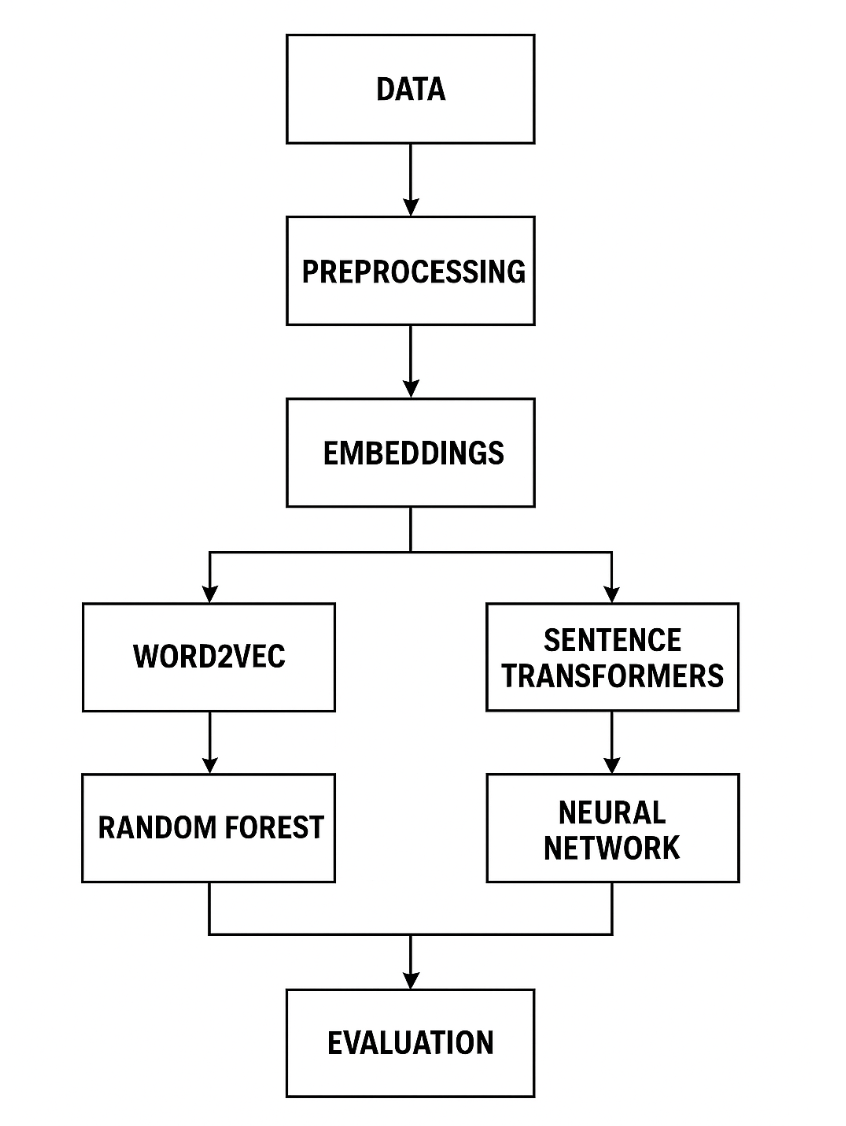

## Step-by-Step Execution Flow
### 1. Load Dataset

- CSV → Pandas DataFrame
    418 rows, 8 columns
- Columns: Date, News, OHLC prices, Volume, Label


### 2. Data Preprocessing

- Clean text (lowercase, remove URLs, punctuation)
- Create features (News_Length, Word_Count, Price_Range)
- Split: 80% train (334 samples) / 20% test (84 samples)

### 3a. Word2Vec Embedding Generation

- Tokenize text → list of words
- Train Word2Vec (vector_size=100, window=5, sg=1)
- Average word vectors per document
- Output: X_train_w2v (334 × 100), X_test_w2v (84 × 100)

### 3b. Sentence Transformer Embedding Generation

- Load pre-trained model: all-MiniLM-L6-v2
- Encode sentences in batches (batch_size=32)
- Clean GPU cache (torch.cuda.empty_cache())
- Output: X_train_st (334 × 384), X_test_st (84 × 384)

### 4a. Train Random Forest Models
#### Model 1: RF + Word2Vec

- Fit RandomForestClassifier on X_train_w2v
- Predict on X_test_w2v

#### Model 2: RF + Sentence Transformer

- Fit RandomForestClassifier on X_train_st
- Predict on X_test_st

### 4b. Train Neural Network Models

**Preprocessing for NN:**

- Map labels: -1→0, 0→1, 1→2
- StandardScaler: fit on train, transform both train/test

#### Model 3: NN + Word2Vec

- Build: Dense(128)→Dropout(0.3)→Dense(64)→Dense(32)→Dense(3)
- Compile: optimizer='adam', loss='sparse_categorical_crossentropy'
- Train: 50 epochs, batch_size=32, validation_split=0.2
- Predict on X_test_w2v_scaled

#### Model 4: NN + Sentence Transformer

- Same architecture as Model 3
- Train on X_train_st_scaled
- Predict on X_test_st_scaled

### 5. Post-process NN Predictions

- Get probability outputs from NN
- argmax to get class (0, 1, 2)
- Inverse mapping: 0→-1, 1→0, 2→1
- Convert back to original labels

### 6. Evaluate All Models
**For each model's predictions:**

- Calculate: Accuracy, Precision, Recall, F1-Score (weighted)
- Generate: Confusion Matrix
- Create: Classification Report
- Record: Training Time
- Store all metrics in results_df

### 7. Compare Model Performance

- Create performance comparison table
- Visualize: Bar charts, scatter plots, heatmaps
- Rank models by F1-score (primary metric)
- Identify best performing model

### 8. Select Best Model

- Find model with highest F1-score
- Display detailed classification report
- Document selection reasoning
- Recommended for deployment

### 9. Generate Insights & Recommendations

- EDA insights
- Model performance analysis
- Business recommendations
- Risk Management
- Governance
- Deployment strategy
- Final deliverable

## **Installing and Importing the necessary libraries**

In [327]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip3 install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2 \
             matplotlib==3.9.2 \
             tensorflow==2.15.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [328]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

%pip install matplotlib seaborn

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To build, tune, and evaluate ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

%pip install tensorflow

# Import TensorFlow and Keras for deep learning model building.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## **Loading the dataset**

In [329]:
# Load the dataset
print("\n=== Loading the Dataset (CSV)===\n")
import os
csv_path = os.path.join(os.getcwd(), 'stock_news.csv')
print('Reading file:', csv_path)
df_original = pd.read_csv(csv_path)
print(f'Data loaded successfully, dataset shape: {df_original.shape}')

# Copying the original dataframe to a new variable for safety
df = df_original.copy()


=== Loading the Dataset (CSV)===

Reading file: /Users/pankajsharma/Documents/projects_gl/stock_news.csv
Data loaded successfully, dataset shape: (418, 8)


## **Data Overview**

In [330]:
print("\n=== DATASET OVERVIEW ===\n")
# Display shape
print(f"Dataset Shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}\n")

# Display first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Display last few rows
print("Last 5 rows of the dataset:")
display(df.tail())

#Data types
print("\n=== DATA TYPES ===")
print(df.dtypes)

# Check for missing values
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Basic statistics
print("\n=== DESCRIPTIVE STATISTICS ===")
display(df.describe())

# Info about dataset
print("\n=== DATASET INFO ===")
df.info()

# Check unique values in Label column
print("\n=== TARGET VARIABLE ANALYSIS ===")
print(f"Unique labels: {df['Label'].unique()}")
print(f"\nLabel distribution:")
print(df['Label'].value_counts())
print(f"\nLabel distribution (%):")
print(df['Label'].value_counts(normalize=True) * 100)



=== DATASET OVERVIEW ===

Dataset Shape: (418, 8)
Number of rows: 418
Number of columns: 8

First 5 rows of the dataset:


,Date,News,Open,High,Low,Close,Volume,Label
0,01-02-2019,The dollar minutes ago tumbled to 106 67 from...,38.72,39.71,38.56,39.48,130672400,1
1,01-02-2019,By Wayne Cole and Swati Pandey SYDNEY Reuters...,38.72,39.71,38.56,39.48,130672400,-1
2,01-02-2019,By Stephen Culp NEW YORK Reuters Wall Stre...,38.72,39.71,38.56,39.48,130672400,0
3,01-02-2019,By Wayne Cole SYDNEY Reuters The Australia...,38.72,39.71,38.56,39.48,130672400,-1
4,01-02-2019,Investing com Asian equities fell in morning...,38.72,39.71,38.56,39.48,130672400,1


Last 5 rows of the dataset:


,Date,News,Open,High,Low,Close,Volume,Label
413,04-26-2019,By Makiko Yamazaki TOKYO Reuters Sony Corp...,51.22,51.25,50.53,51.08,74596400,1
414,04-29-2019,By Akanksha Rana and Kenneth Li Reuters Sp...,51.10,51.49,50.97,51.15,88818800,1
415,04-29-2019,shares rose 3 5 after the company s first qua...,51.10,51.49,50.97,51.15,88818800,1
416,04-29-2019,By Caroline Valetkevitch NEW YORK Reuters ...,51.10,51.49,50.97,51.15,88818800,1
417,04-29-2019,By Arjun Panchadar and Paresh Dave Reuters ...,51.10,51.49,50.97,51.15,88818800,1



=== DATA TYPES ===
Date       object
News       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Label       int64
dtype: object

=== MISSING VALUES ===
Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

Total missing values: 0

=== DESCRIPTIVE STATISTICS ===


,Open,High,Low,Close,Volume,Label
count,418.000000,418.000000,418.000000,418.000000,4.180000e+02,418.000000
mean,42.308852,42.787321,41.923732,42.418517,1.294225e+08,0.308612
std,4.947134,4.947413,4.967880,4.999867,4.574550e+07,0.943473
min,35.990000,36.430000,35.500000,35.550000,4.544800e+07,-1.000000
25%,38.130000,38.420000,37.720000,38.270000,1.029072e+08,-1.000000
50%,41.530000,42.250000,41.140000,41.610000,1.156272e+08,1.000000
75%,47.190000,47.427500,46.480000,47.032500,1.511252e+08,1.000000
max,51.840000,52.120000,51.760000,51.870000,3.652488e+08,1.000000



=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    418 non-null    object 
 1   News    418 non-null    object 
 2   Open    418 non-null    float64
 3   High    418 non-null    float64
 4   Low     418 non-null    float64
 5   Close   418 non-null    float64
 6   Volume  418 non-null    int64  
 7   Label   418 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 26.3+ KB

=== TARGET VARIABLE ANALYSIS ===
Unique labels: [ 1 -1  0]

Label distribution:
Label
 1    270
-1    141
 0      7
Name: count, dtype: int64

Label distribution (%):
Label
 1    64.593301
-1    33.732057
 0     1.674641
Name: proportion, dtype: float64


## **Exploratory Data Analysis**

In [331]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)


# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create additional features for analysis
df['News_Length'] = df['News'].str.len()
df['Word_Count'] = df['News'].str.split().str.len()
df['Price_Range'] = df['High'] - df['Low']
df['Price_Change'] = df['Close'].pct_change() * 100
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day_of_Week'] = df['Date'].dt.day_name()

print("\nNew features created for analysis:")
print("- News_Length: Character count in news")
print("- Word_Count: Number of words in news")
print("- Price_Range: Daily price range (High - Low)")
print("- Price_Change: Percentage change in closing price")
print(df[['News_Length', 'Word_Count', 'Price_Range', 'Price_Change']].head())



EXPLORATORY DATA ANALYSIS

New features created for analysis:
- News_Length: Character count in news
- Word_Count: Number of words in news
- Price_Range: Daily price range (High - Low)
- Price_Change: Percentage change in closing price
   News_Length  Word_Count  Price_Range  Price_Change
0          607         117         1.15           NaN
1         1867         334         1.15           0.0
2         2981         540         1.15           0.0
3         3178         584         1.15           0.0
4         1894         329         1.15           0.0


### **Univariate Analysis**

* Distribution of Sentiment Labels (Count)
* Distribution of Sentiment Labels (Pie Chart)
* Distribution of Closing Prices
* Distribution of Trading Volume
* Distribution of News Length
* KDE Plot (Kernel Density Estimation) - Probability Density plot showing the distribution of these four stock price variables.
* Plot a histogram of the 'Volume' column
* Distribution of Word Count
* Distribution of Daily Price Range
* Distribution of Opening Prices
* Box plot of Closing Price by Sentiment.


--- UNIVARIATE ANALYSIS ---

# 1. Distribution of Sentiment Labels (Count)...


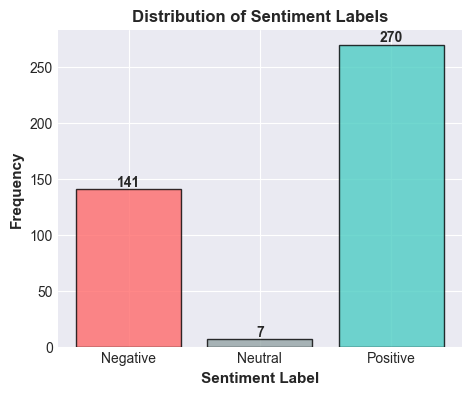

In [332]:
print("\n--- UNIVARIATE ANALYSIS ---\n")

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create comprehensive univariate visualizations
fig = plt.figure(figsize=(24, 14))

# 1. Distribution of Sentiment Labels (Count)
print("# 1. Distribution of Sentiment Labels (Count)...")
plt.subplot(3, 4, 1)
sentiment_counts = df['Label'].value_counts().sort_index()
colors = ['#ff6b6b', '#95a5a6', '#4ecdc4']
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors, alpha=0.8, edgecolor='black')
plt.xlabel('Sentiment Label', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Distribution of Sentiment Labels', fontsize=12, fontweight='bold')
plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')


# 2. Distribution of Sentiment Labels (Pie Chart)...


Text(0.5, 1.0, 'Sentiment Label Proportion')

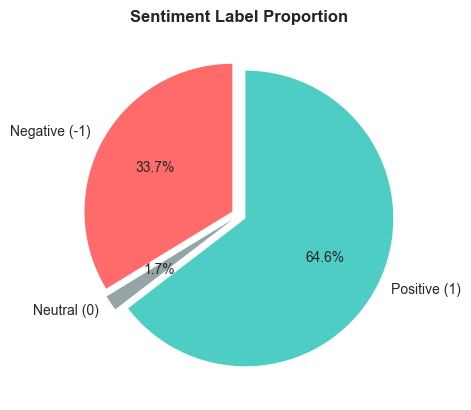

In [333]:
# 2. Distribution of Sentiment Labels (Pie Chart)
print("# 2. Distribution of Sentiment Labels (Pie Chart)...")
plt.subplot(1,1,1)
labels_pie = ['Negative (-1)', 'Neutral (0)', 'Positive (1)']
plt.pie(sentiment_counts.values, labels=labels_pie, autopct='%1.1f%%', 
        colors=colors, startangle=90, explode=(0.05, 0.05, 0.05))
plt.title('Sentiment Label Proportion', fontsize=12, fontweight='bold')


# 3. Distribution of Closing Prices...


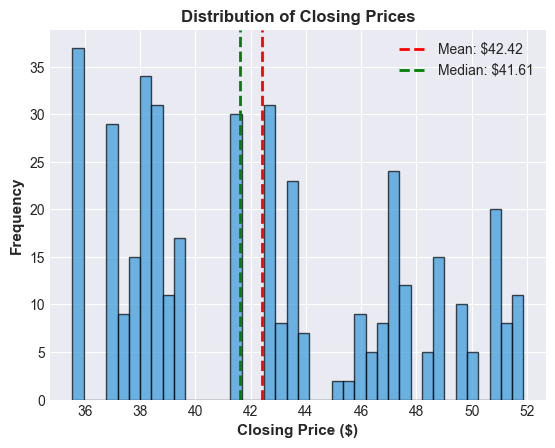

In [334]:
# 3. Distribution of Closing Prices
print("# 3. Distribution of Closing Prices...")
plt.subplot(1,1,1)
plt.hist(df['Close'], bins=40, alpha=0.7, color='#3498db', edgecolor='black')
plt.axvline(df['Close'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df["Close"].mean():.2f}')
plt.axvline(df['Close'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${df["Close"].median():.2f}')
plt.xlabel('Closing Price ($)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Distribution of Closing Prices', fontsize=12, fontweight='bold')
plt.legend()

# 4. Distribution of Trading Volume...


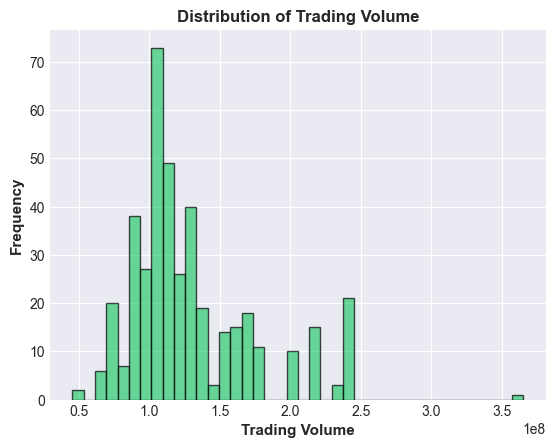

In [335]:
# 4. Distribution of Trading Volume
print("# 4. Distribution of Trading Volume...")
plt.subplot(1,1,1)
plt.hist(df['Volume'], bins=40, alpha=0.7, color='#2ecc71', edgecolor='black')
plt.xlabel('Trading Volume', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Distribution of Trading Volume', fontsize=12, fontweight='bold')
plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))


# 5. Distribution of News Length...


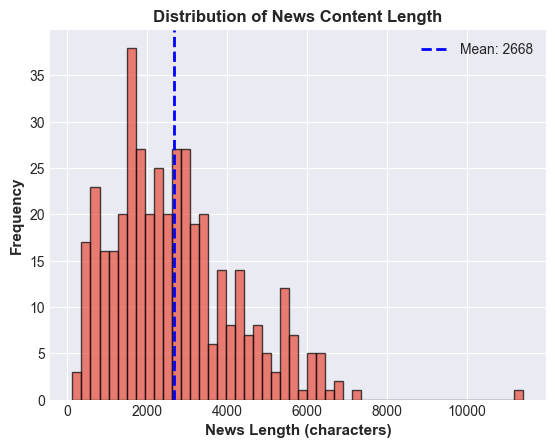

In [336]:
# 5. Distribution of News Length
print("# 5. Distribution of News Length...")
plt.subplot(1,1,1)
plt.hist(df['News_Length'], bins=50, alpha=0.7, color='#e74c3c', edgecolor='black')
plt.axvline(df['News_Length'].mean(), color='blue', linestyle='--', linewidth=2, 
            label=f'Mean: {df["News_Length"].mean():.0f}')
plt.xlabel('News Length (characters)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Distribution of News Content Length', fontsize=12, fontweight='bold')
plt.legend()

# 6. Plot KDE for the 'Open', 'High', 'Low', 'Close' columns of the 'stock' DataFrame...


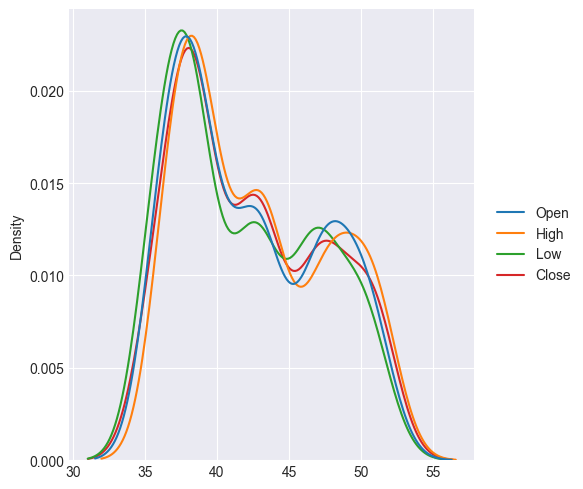

In [337]:
# 6. Plot KDE for the 'Open', 'High', 'Low', 'Close' columns of the 'stock' DataFrame.
print("# 6. Plot KDE for the 'Open', 'High', 'Low', 'Close' columns of the 'stock' DataFrame...")
sns.displot(data=df[['Open','High','Low','Close']], kind='kde', palette="tab10");

# 7. Plots a histogram of the 'Volume' column...


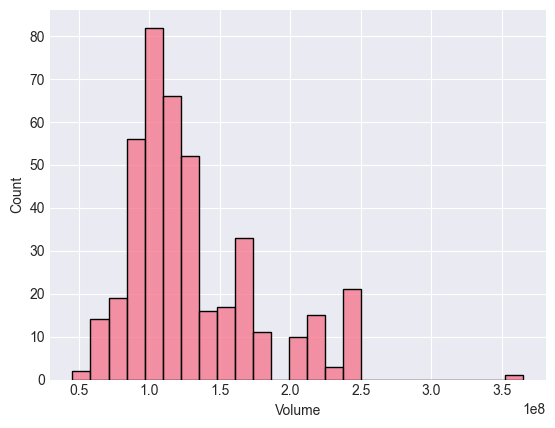

In [338]:
# 7. Plots a histogram of the 'Volume' column
print("# 7. Plots a histogram of the 'Volume' column...")
sns.histplot(df, x='Volume');  

# 8. Distribution of Word Count...


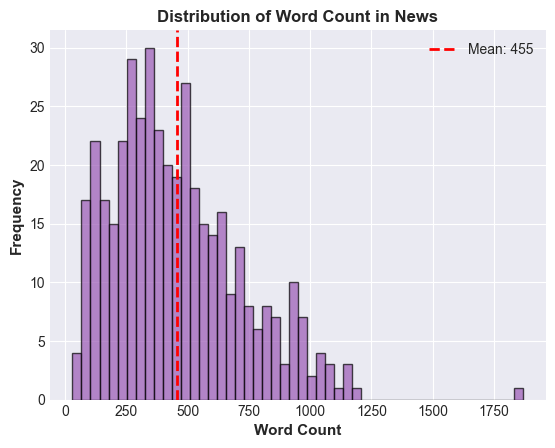

In [339]:
# 8. Distribution of Word Count
print("# 8. Distribution of Word Count...")
plt.subplot(1,1,1)
plt.hist(df['Word_Count'], bins=50, alpha=0.7, color='#9b59b6', edgecolor='black')
plt.axvline(df['Word_Count'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {df["Word_Count"].mean():.0f}')
plt.xlabel('Word Count', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Distribution of Word Count in News', fontsize=12, fontweight='bold')
plt.legend()

# 9. Distribution of Daily Price Range...


Text(0.5, 1.0, 'Distribution of Daily Price Range')

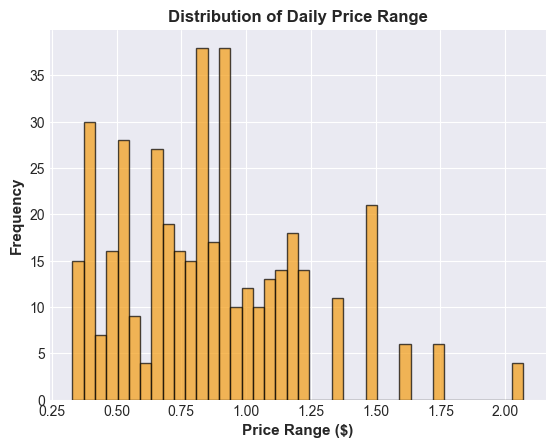

In [340]:
# 9. Distribution of Daily Price Range
print("# 9. Distribution of Daily Price Range...")
plt.subplot(1,1,1)
plt.hist(df['Price_Range'], bins=40, alpha=0.7, color='#f39c12', edgecolor='black')
plt.xlabel('Price Range ($)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Distribution of Daily Price Range', fontsize=12, fontweight='bold')


# 10. Distribution of Opening Prices...


Text(0.5, 1.0, 'Distribution of Opening Prices')

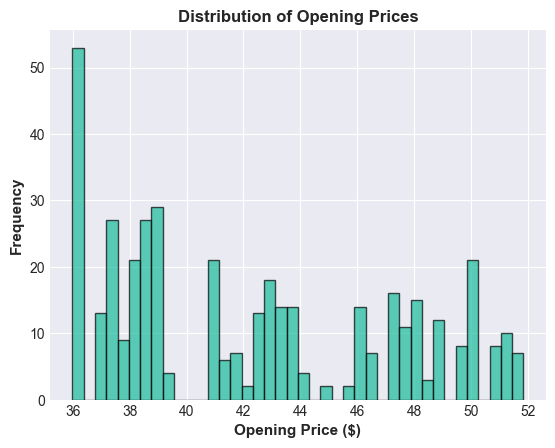

In [341]:
# 10. Distribution of Opening Prices
print("# 10. Distribution of Opening Prices...")
plt.subplot(1,1,1)
plt.hist(df['Open'], bins=40, alpha=0.7, color='#1abc9c', edgecolor='black')
plt.xlabel('Opening Price ($)', fontsize=11, fontweight='bold')
plt.ylabel('Frequency', fontsize=11, fontweight='bold')
plt.title('Distribution of Opening Prices', fontsize=12, fontweight='bold')


#11. Box plot of Closing Price by Sentiment--candle chart...


([<matplotlib.axis.XTick at 0x3abe97910>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')])

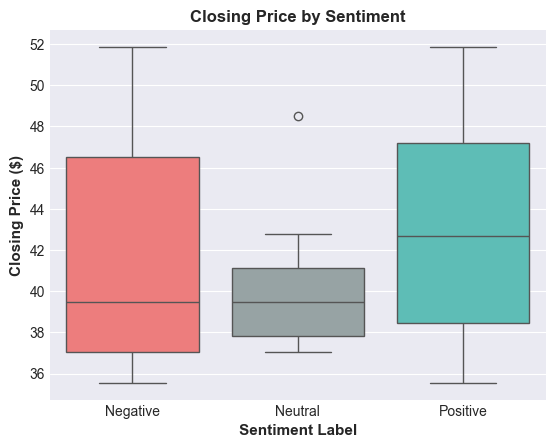

In [342]:
#11. Box plot of Closing Price by Sentiment--candle chart.
print("#11. Box plot of Closing Price by Sentiment--candle chart...")
plt.subplot(1,1,1)
sns.boxplot(x='Label', y='Close', data=df, palette=colors)
plt.xlabel('Sentiment Label', fontsize=11, fontweight='bold')
plt.ylabel('Closing Price ($)', fontsize=11, fontweight='bold')
plt.title('Closing Price by Sentiment', fontsize=12, fontweight='bold')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

In [343]:
# Print statistical summaries
print("\n=== UNIVARIATE STATISTICS ===\n")

print("1. SENTIMENT LABEL STATISTICS:")
print(df['Label'].describe())

print("\n2. STOCK PRICE STATISTICS:")
print(df[['Open', 'High', 'Low', 'Close']].describe())

print("\n3. VOLUME STATISTICS:")
print(df['Volume'].describe())

print("\n4. NEWS LENGTH STATISTICS:")
print(df['News_Length'].describe())

print("\n5. WORD COUNT STATISTICS:")
print(df['Word_Count'].describe())


=== UNIVARIATE STATISTICS ===

1. SENTIMENT LABEL STATISTICS:
count    418.000000
mean       0.308612
std        0.943473
min       -1.000000
25%       -1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Label, dtype: float64

2. STOCK PRICE STATISTICS:
             Open        High         Low       Close
count  418.000000  418.000000  418.000000  418.000000
mean    42.308852   42.787321   41.923732   42.418517
std      4.947134    4.947413    4.967880    4.999867
min     35.990000   36.430000   35.500000   35.550000
25%     38.130000   38.420000   37.720000   38.270000
50%     41.530000   42.250000   41.140000   41.610000
75%     47.190000   47.427500   46.480000   47.032500
max     51.840000   52.120000   51.760000   51.870000

3. VOLUME STATISTICS:
count    4.180000e+02
mean     1.294225e+08
std      4.574550e+07
min      4.544800e+07
25%      1.029072e+08
50%      1.156272e+08
75%      1.511252e+08
max      3.652488e+08
Name: Volume, dtype: float64

4. NEW

#### Summary from few above charts here.

- From Chart 1 & 2:
   - Financial media is highly opinionated, not neutral.
   - Models might predict “positive” too often (biased towards majority class). 
   - Need techniques like: F1 score, not just accuracy.

- From Chart 3
   - This price distribution combined with 64% positive sentiment suggests an actively traded, moderately bullish stock with significant price swings

- From Chart 4
   - This volume distribution shows actively traded stocks with occasionally peak of intense trading activity.

- From chart 5
   - Most news articles are short-to-medium length (2,000-3,000 characters), with a right-skewed distribution showing occasional very long articles up to 12,000 characters, indicating a mix of brief headlines and detailed investigative pieces.

- Univariate Stats shows: 
   - Decent sample size of 418 for modeling.
   - No missing values. 
   - Positive Sentiment aligns with appreciating prices as sentiments showing .31 mean to Label.


### **Bivariate Analysis**

* Correlation Matrix - Key variables.
* Label vs Stock Prices (Box Plots) - This will help us know how stock prices vary with sentiment
* Volume by Sentiment (Box Plots) - This will help us understand how trading volume varies with sentiment
* Volume vs Close Price by Sentiment (Scatter Plot) - This will help us see if there's a relationship between trading volume and closing price, colored by sentiment
* Price Change Distribution by Sentiment - This will help us understand how price changes vary with sentiment and we will know about the impact of stock price on sentiment
* News Length vs Sentiment vs Volume - This will help us see how news length relates to trading volume, colored by sentiment and we will know about the impact of news length on trading volume.
* Additional bivariate analysis- relationships between sentiment, stock prices, volume, and time. - This will help us understand relationships between sentiment, stock prices, volume, and time and we will know about the impact of stock prices, volume, and time on sentiment


--- BIVARIATE ANALYSIS ---

# 1. Correlation Matrix...


Text(0.5, 1.0, 'Correlation Matrix of Key Variables')

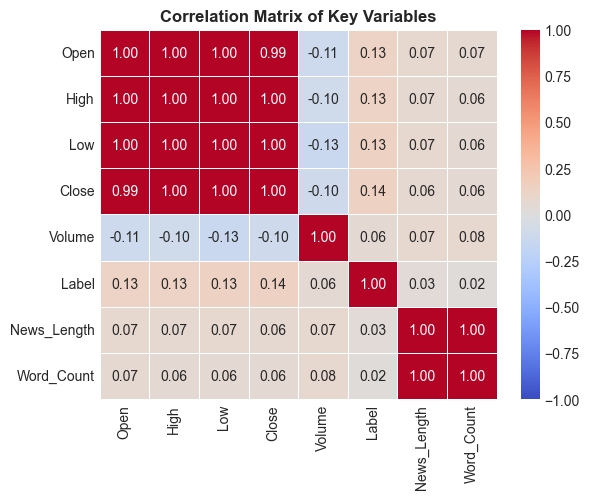

In [344]:
print("\n--- BIVARIATE ANALYSIS ---\n")

# Create bivariate visualizations

# 1. Correlation Matrix
print("# 1. Correlation Matrix...")
plt.subplot(1,1,1)
cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'News_Length', 'Word_Count']
correlation_matrix = df[cols].corr()
sns.heatmap(
   correlation_matrix, annot=True, vmin=-1, vmax=1,linewidths=0.5, fmt=".2f", cmap="coolwarm"
)
plt.title('Correlation Matrix of Key Variables', fontsize=12, fontweight='bold')


# 2. Label vs Stock Prices (Box Plots)...


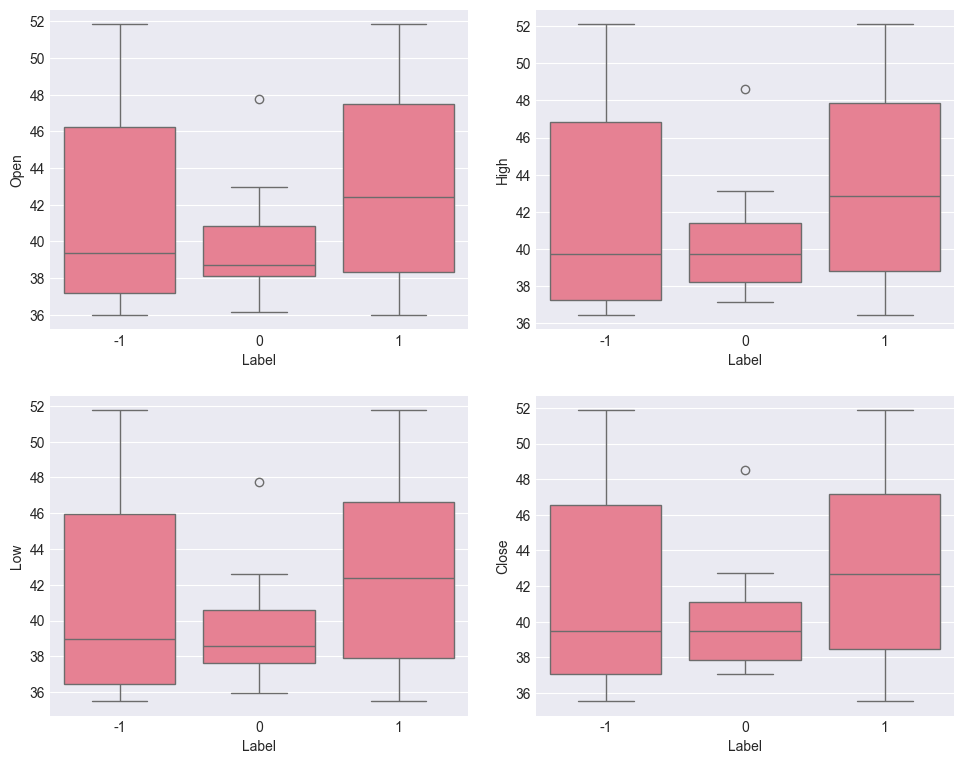

In [345]:
# 2. Label vs Stock Prices (Box Plots)
# Create box plots for Open, High, Low, Close prices grouped by Sentiment Label
# This will help us know how stock prices vary with sentiment
print("# 2. Label vs Stock Prices (Box Plots)...")
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

#3. Box plot of Volume by Sentiment...


<Axes: xlabel='Label', ylabel='Volume'>

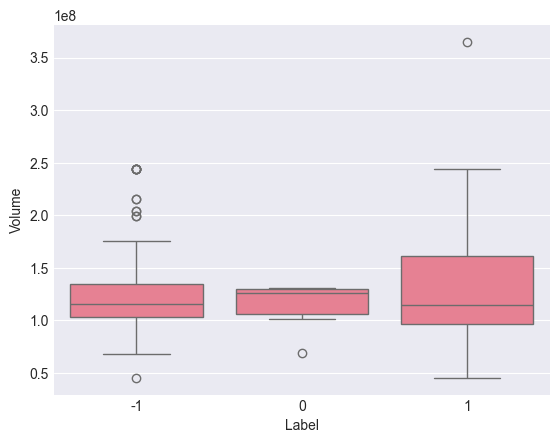

In [346]:
#3. Box plot of Volume by Sentiment
#This will help us understand how trading volume varies with sentiment
print("#3. Box plot of Volume by Sentiment...")
sns.boxplot(
    data=df, x="Label", y="Volume" 
)

# 4. Scatter: Volume vs Close Price by Sentiment...


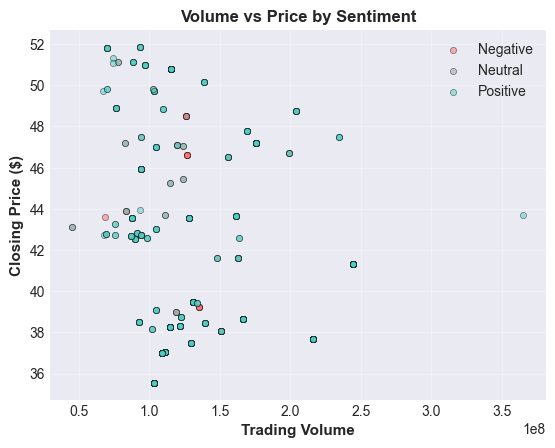

In [347]:
# 4. Scatter: Volume vs Close Price by Sentiment
# This will help us see if there's a relationship between trading volume and closing price, colored by sentiment
print("# 4. Scatter: Volume vs Close Price by Sentiment...")
plt.subplot(1,1,1)
for label, color, name in zip([-1, 0, 1], colors, ['Negative', 'Neutral', 'Positive']):
    subset = df[df['Label'] == label]
    plt.scatter(subset['Volume'], subset['Close'], c=color, alpha=0.5, 
                label=name, s=20, edgecolors='black', linewidth=0.5)
plt.xlabel('Trading Volume', fontsize=11, fontweight='bold')
plt.ylabel('Closing Price ($)', fontsize=11, fontweight='bold')
plt.title('Volume vs Price by Sentiment', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 5. Price Change Distribution by Sentiment...


([<matplotlib.axis.XTick at 0x3fb5d4d90>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')])

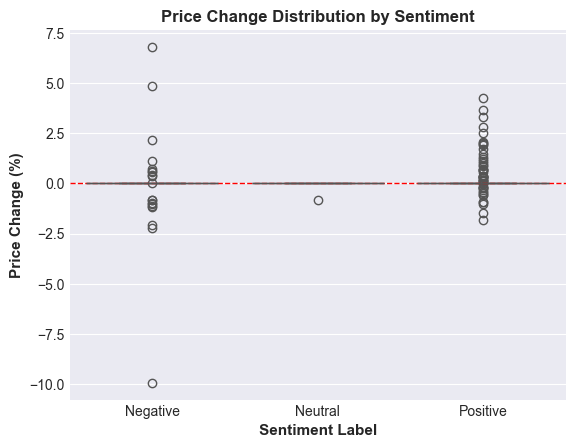

In [348]:
# 5. Price Change Distribution by Sentiment
# This will help us understand how price changes vary with sentiment
# And we will know about the impact of stock price on sentiment.
print("# 5. Price Change Distribution by Sentiment...")
plt.subplot(1,1,1)
df_clean = df.dropna(subset=['Price_Change'])
sns.boxplot(x='Label', y='Price_Change', data=df_clean, palette=colors)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Sentiment Label', fontsize=11, fontweight='bold')
plt.ylabel('Price Change (%)', fontsize=11, fontweight='bold')
plt.title('Price Change Distribution by Sentiment', fontsize=12, fontweight='bold')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])

# 6. News Length vs Sentiment vs Volume...


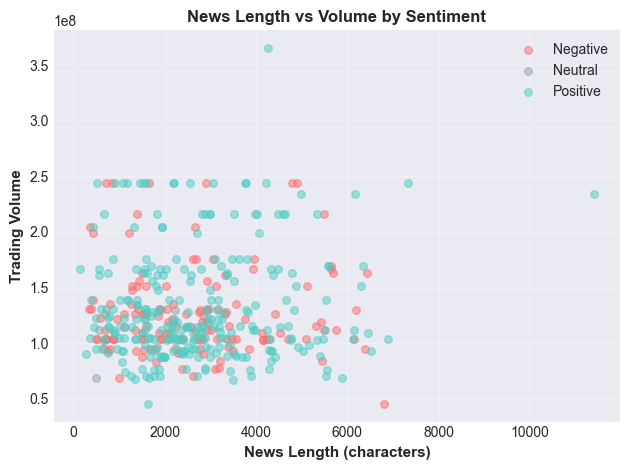

In [349]:
# 6. News Length vs Sentiment vs Volume
# This will help us see how news length relates to trading volume, colored by sentiment
# And we will know about the impact of news length on trading volume.
print("# 6. News Length vs Sentiment vs Volume...")
plt.subplot(1,1,1)
for label, color, name in zip([-1, 0, 1], colors, ['Negative', 'Neutral', 'Positive']):
    subset = df[df['Label'] == label]
    plt.scatter(subset['News_Length'], subset['Volume'], c=color, 
                alpha=0.5, label=name, s=30)
plt.xlabel('News Length (characters)', fontsize=11, fontweight='bold')
plt.ylabel('Trading Volume', fontsize=11, fontweight='bold')
plt.title('News Length vs Volume by Sentiment', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Additional bivariate analysis- relationships between sentiment, stock prices, volume, and time...


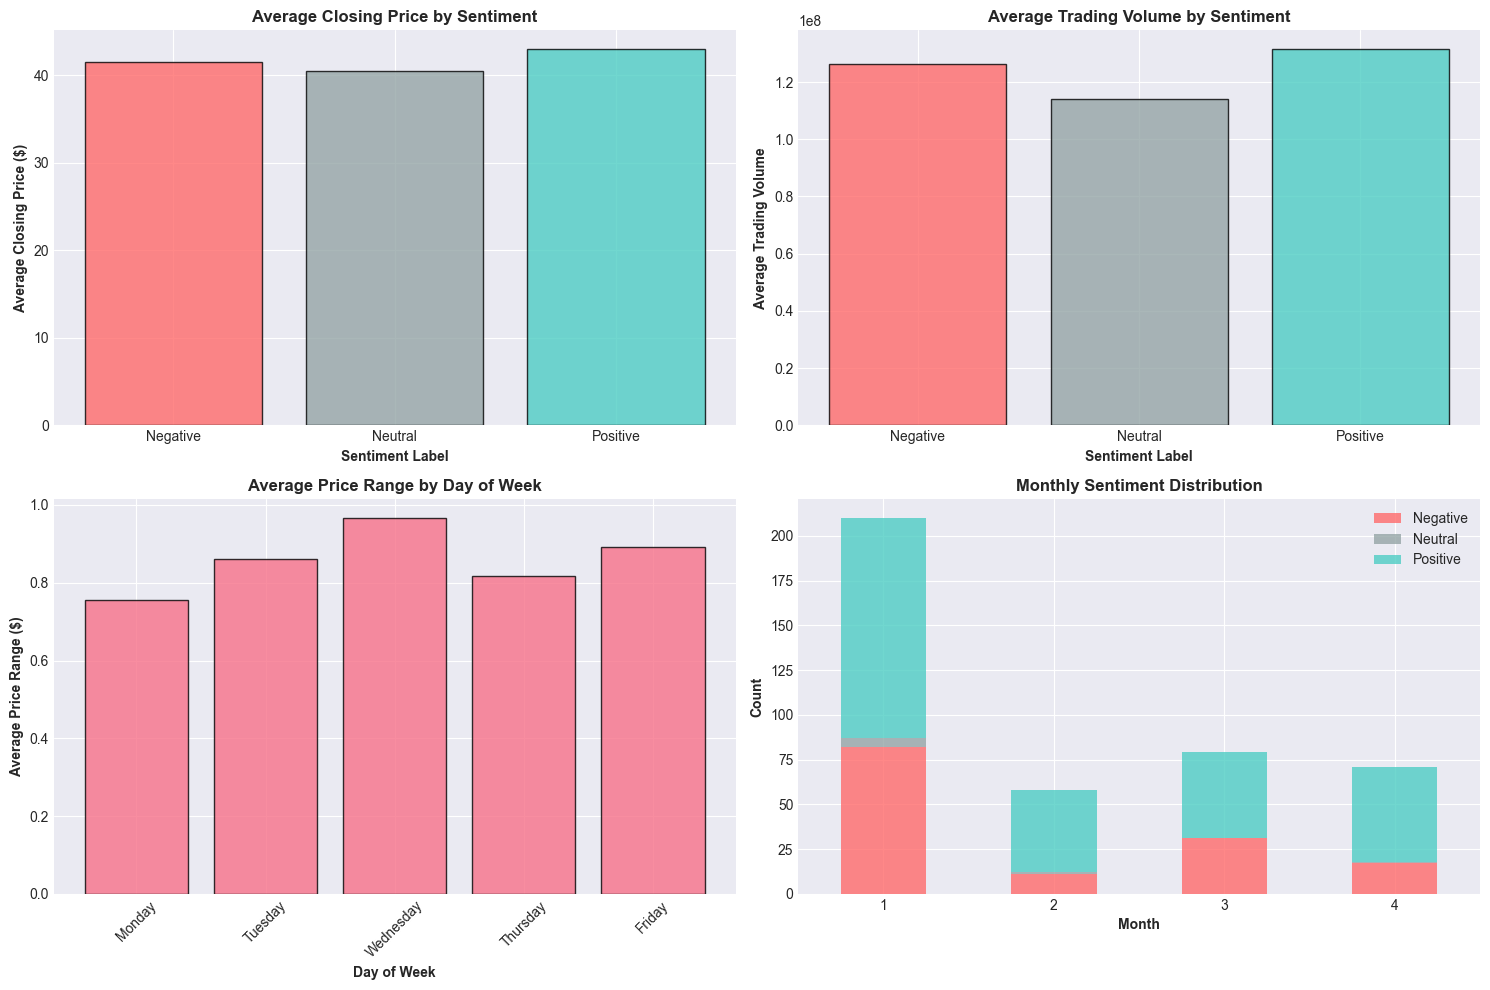

In [350]:
# 7. Additional bivariate analysis
# Create additional bivariate visualizations
# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# This will help us understand relationships between sentiment, stock prices, volume, and time.
# And we will know about the impact of stock prices, volume, and time on sentiment.
print("# 7. Additional bivariate analysis- relationships between sentiment, stock prices, volume, and time...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average closing price by sentiment
axes[0, 0].bar([-1, 0, 1], df.groupby('Label')['Close'].mean(), 
               color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Sentiment Label', fontweight='bold')
axes[0, 0].set_ylabel('Average Closing Price ($)', fontweight='bold')
axes[0, 0].set_title('Average Closing Price by Sentiment', fontweight='bold')
axes[0, 0].set_xticks([-1, 0, 1])
axes[0, 0].set_xticklabels(['Negative', 'Neutral', 'Positive'])

# Average volume by sentiment
axes[0, 1].bar([-1, 0, 1], df.groupby('Label')['Volume'].mean(), 
               color=colors, alpha=0.8, edgecolor='black')
axes[0, 1].set_xlabel('Sentiment Label', fontweight='bold')
axes[0, 1].set_ylabel('Average Trading Volume', fontweight='bold')
axes[0, 1].set_title('Average Trading Volume by Sentiment', fontweight='bold')
axes[0, 1].set_xticks([-1, 0, 1])
axes[0, 1].set_xticklabels(['Negative', 'Neutral', 'Positive'])
axes[0, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Price range by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_price = df.groupby('Day_of_Week')['Price_Range'].mean().reindex(day_order).dropna()
axes[1, 0].bar(range(len(day_price)), day_price.values, alpha=0.8, edgecolor='black')
axes[1, 0].set_xlabel('Day of Week', fontweight='bold')
axes[1, 0].set_ylabel('Average Price Range ($)', fontweight='bold')
axes[1, 0].set_title('Average Price Range by Day of Week', fontweight='bold')
axes[1, 0].set_xticks(range(len(day_price)))
axes[1, 0].set_xticklabels(day_price.index, rotation=45)

# Sentiment count by month
monthly_sentiment = df.groupby(['Month', 'Label']).size().unstack(fill_value=0)
monthly_sentiment.plot(kind='bar', stacked=True, color=colors, 
                       alpha=0.8, ax=axes[1, 1])
axes[1, 1].set_xlabel('Month', fontweight='bold')
axes[1, 1].set_ylabel('Count', fontweight='bold')
axes[1, 1].set_title('Monthly Sentiment Distribution', fontweight='bold')
axes[1, 1].legend(['Negative', 'Neutral', 'Positive'])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [351]:
# Print correlation insights
print("=== BIVARIATE STATISTICS ===\n")

print("1. CORRELATION WITH SENTIMENT:")
print(f"   - Close Price: {df['Label'].corr(df['Close']):.4f}")
print(f"   - Volume: {df['Label'].corr(df['Volume']):.4f}")
print(f"   - News Length: {df['Label'].corr(df['News_Length']):.4f}")

print("\n2. AVERAGE METRICS BY SENTIMENT:")
sentiment_stats = df.groupby('Label')[['Close', 'Volume', 'News_Length', 'Word_Count']].mean()
print(sentiment_stats)

print("\n3. PRICE CHANGE BY SENTIMENT:")
if 'Price_Change' in df.columns:
    price_change_stats = df.groupby('Label')['Price_Change'].agg(['mean', 'median', 'std'])
    print(price_change_stats)

=== BIVARIATE STATISTICS ===

1. CORRELATION WITH SENTIMENT:
   - Close Price: 0.1393
   - Volume: 0.0553
   - News Length: 0.0346

2. AVERAGE METRICS BY SENTIMENT:
           Close        Volume  News_Length  Word_Count
Label                                                  
-1     41.496525  1.262686e+08  2628.865248  453.205674
 0     40.422857  1.141852e+08  1196.142857  207.571429
 1     42.951741  1.314646e+08  2726.577778  462.437037

3. PRICE CHANGE BY SENTIMENT:
           mean  median       std
Label                            
-1    -0.017867     0.0  1.171756
 0    -0.115088     0.0  0.304493
 1     0.114083     0.0  0.592291


In [352]:
print("\n=== KEY OBSERVATIONS FROM EDA ===")
print("""
1. SENTIMENT PATTERNS:
    - Positive sentiment dominates the dataset, followed by negative and very few neutral samples.
    - Sentiment labels show weak linear correlation with numeric features, suggesting text features are more informative.

2. STOCK PRICE PATTERNS:
    - Stock prices (Open, High, Low, Close) are highly correlated, indicating similar daily movement.
    - Price volatility (Price_Range) and trading volume does not show spikes that often align with major news events.
    - Both positive and negative sentiments are associated with higher average closing prices and volumes compared to neutral sentiment.
    - Determining Strong sentiment (positive or negative) is linked to higher stock prices and volumes, while neutral sentiment corresponds to lower prices and volumes.

3. NEWS CHARACTERISTICS:
    - News articles vary widely in length and word count.
    - News length and word count are correlated.

4. VOLUME PATTERNS:
   - Strong sentiment (positive/negative) drives higher volume than neutral
   - Distribution heavily right-skewed with outliers up to 370M shares
   - Typical range: 80-120M shares

4. ACTIONABLE INSIGHTS:
    - Focus on text embeddings for sentiment prediction, as numeric features alone are insufficient.
    - Engineer features such as price change, price range, and log-transformed volume for modeling.
    - Address class imbalance due to few neutral samples, We should consider Binary classification but for learning purpose here we will still proceed with 3 class.
    - Align major news dates with price/volume spikes for deeper analysis.
""")


=== KEY OBSERVATIONS FROM EDA ===

1. SENTIMENT PATTERNS:
    - Positive sentiment dominates the dataset, followed by negative and very few neutral samples.
    - Sentiment labels show weak linear correlation with numeric features, suggesting text features are more informative.

2. STOCK PRICE PATTERNS:
    - Stock prices (Open, High, Low, Close) are highly correlated, indicating similar daily movement.
    - Price volatility (Price_Range) and trading volume does not show spikes that often align with major news events.
    - Both positive and negative sentiments are associated with higher average closing prices and volumes compared to neutral sentiment.
    - Determining Strong sentiment (positive or negative) is linked to higher stock prices and volumes, while neutral sentiment corresponds to lower prices and volumes.

3. NEWS CHARACTERISTICS:
    - News articles vary widely in length and word count.
    - News length and word count are correlated.

4. VOLUME PATTERNS:
   - Strong se

## **Data Preprocessing**

In [353]:
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80 + "\n")

# Lets check the date column and its statistics
df['Date'].describe()

# Text preprocessing
import re
import string

def preprocess_text(text):
    """
    Preprocess text by converting to lowercase, removing special characters,
    and extra whitespace
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

# Apply preprocessing to the 'News' column
print("Preprocessing news text...")
df['Processed_News'] = df['News'].progress_apply(preprocess_text)
print("----- Text preprocessing completed------\n")

# Display examples
print("Sample of original vs preprocessed text:")
for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print(f"Original: {df['News'].iloc[i][:150]}...")
    print(f"Processed: {df['Processed_News'].iloc[i][:150]}...")


DATA PREPROCESSING

Preprocessing news text...


100%|██████████| 418/418 [00:00<00:00, 13464.24it/s]

----- Text preprocessing completed------

Sample of original vs preprocessed text:

--- Example 1 ---
Original: The dollar minutes ago tumbled to  106 67 from above  109 a few trades earlier  It s since bounced a hair to  107 16  FXY  3 6  after hoursAlongside  ...
Processed: the dollar minutes ago tumbled to from above a few trades earlier it s since bounced a hair to fxy after hoursalongside money poured into u s governme...

--- Example 2 ---
Original: By Wayne Cole and Swati Pandey SYDNEY  Reuters    The Japanese yen soared in early Asian trading on Thursday as the break of key technical levels trig...
Processed: by wayne cole and swati pandey sydney reuters the japanese yen soared in early asian trading on thursday as the break of key technical levels triggere...

--- Example 3 ---
Original: By Stephen Culp NEW YORK  Reuters    Wall Street edged higher on Wednesday after stumbling out of the starting gate on the first trading day of 2019  ...
Processed: by stephen culp new york re

### Split features and target

In [354]:
# Split features and target
print("\nSplitting features and target variable...")
X = df['Processed_News']
y = df['Label']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")


Splitting features and target variable...
Features (X) shape: (418,)
Target (y) shape: (418,)


### Train Test Split

In [355]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

print("\nTraining set label distribution:")
print(y_train.value_counts().sort_index())

print("\nTest set label distribution:")
print(y_test.value_counts().sort_index())


Training set size: 334 (79.9%)
Test set size: 84 (20.1%)

Training set label distribution:
Label
-1    113
 0      5
 1    216
Name: count, dtype: int64

Test set label distribution:
Label
-1    28
 0     2
 1    54
Name: count, dtype: int64


## **Word Embeddings**

In [356]:
print("\n" + "="*80)
print("WORD EMBEDDINGS")
print("="*80 + "\n")


WORD EMBEDDINGS



#### **Word2Vec**

In [357]:
# ------------------- WORD2VEC EMBEDDINGS -------------------
print("--- WORD2VEC EMBEDDINGS ---\n")

# Tokenize for Word2Vec
print("Tokenizing text for Word2Vec...")
tokenized_train = [text.split() for text in X_train]
tokenized_test = [text.split() for text in X_test]

# Display first 2 tokenized examples
tokenized_train[:2]

--- WORD2VEC EMBEDDINGS ---

Tokenizing text for Word2Vec...


[['by',
  'carl',
  'o',
  'donnell',
  'and',
  'joshua',
  'franklin',
  'reuters',
  'lyft',
  'inc',
  'nasdaq',
  'lyft',
  'was',
  'valued',
  'at',
  'billion',
  'in',
  'the',
  'first',
  'initial',
  'public',
  'offering',
  'ipo',
  'of',
  'a',
  'ride',
  'hailing',
  'startup',
  'on',
  'thursday',
  'raising',
  'more',
  'than',
  'it',
  'had',
  'set',
  'off',
  'to',
  'do',
  'as',
  'investors',
  'overlooked',
  'uncertainty',
  'over',
  'its',
  'path',
  'to',
  'becoming',
  'a',
  'profitable',
  'company',
  'lyft',
  's',
  'ipo',
  'sets',
  'the',
  'stage',
  'for',
  'the',
  'stock',
  'market',
  'debut',
  'of',
  'larger',
  'rival',
  'uber',
  'technologies',
  'inc',
  'which',
  'reuters',
  'has',
  'reported',
  'will',
  'kick',
  'off',
  'in',
  'april',
  'uber',
  'has',
  'been',
  'told',
  'by',
  'its',
  'investment',
  'bankers',
  'that',
  'it',
  'could',
  'be',
  'valued',
  'at',
  'as',
  'much',
  'as',
  'billion',
  '

In [358]:
# Train Word2Vec model
print("\nTraining Word2Vec model...")
start_time = time.time()

word2vec_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=300,
    window=10,
    min_count=1,
    workers=4,
    sg=1,  # Skip-gram
    epochs=20,
    seed=42
)

training_time = time.time() - start_time
print(f"Word2Vec model trained in {training_time:.2f} seconds")
print(f"Vocabulary size: {len(word2vec_model.wv)}")

# List of words in the vocabulary
print(word2vec_model.wv.index_to_key)


Training Word2Vec model...
Word2Vec model trained in 7.01 seconds
Vocabulary size: 10816
['the', 'to', 'in', 'a', 'of', 'and', 's', 'on', 'for', 'that', 'said', 'its', 'as', 'it', 'apple', 'is', 'with', 'by', 'at', 'from', 'u', 'nasdaq', 'was', 'percent', 'china', 'year', 'has', 'are', 'after', 'which', 'company', 'an', 'be', 'will', 'have', 'this', 'more', 'new', 'trade', 'but', 'not', 'than', 'reuters', 'inc', 'up', 'market', 'nyse', 'also', 'last', 'were', 'aapl', 'or', 'sales', 'would', 'about', 'billion', 'he', 'growth', 'we', 'quarter', 'chinese', 'revenue', 'had', 'their', 'while', 'some', 'shares', 'could', 'they', 'million', 'week', 'down', 'been', 'iphone', 'over', 'stock', 'data', 'first', 'companies', 'global', 'two', 'investors', 'economy', 'other', 'fell', 'p', 'world', 't', 'earnings', 'expected', 'month', 'since', 'economic', 'markets', 'according', 'analysts', 'stocks', 'rose', 'business', 'one', 'trump', 'when', 'if', 'time', 'technology', 'who', 'may', 'day', 'such'

In [359]:
# Function to get average word vector for a text
def get_avg_word_vector(tokens, model):
    """
    Get average word vector for a list of tokens
    Returns zero vector if no words are in vocabulary
    """
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
    
# Generate Word2Vec embeddings
print("\nGenerating Word2Vec embeddings...")

# Apply the function directly to tokenized data
embeddings_train = [get_avg_word_vector(tokens, word2vec_model) for tokens in tqdm(tokenized_train, desc="Train embeddings")]
embeddings_test = [get_avg_word_vector(tokens, word2vec_model) for tokens in tqdm(tokenized_test, desc="Test embeddings")]

# Convert to numpy arrays
X_train_w2v = np.array(embeddings_train)
X_test_w2v = np.array(embeddings_test)
print(f"Word2Vec Embeddings - Training set shape: {X_train_w2v.shape}")
print(f"Word2Vec Embeddings - Test set shape: {X_test_w2v.shape}")


Generating Word2Vec embeddings...


Test embeddings: 100%|██████████| 84/84 [00:00<00:00, 4149.99it/s]

Word2Vec Embeddings - Training set shape: (334, 300)
Word2Vec Embeddings - Test set shape: (84, 300)


### **Sentence Transformer**

- Model Used - ProsusAI/finbert - Which is one of the domain specific model

In [360]:
# ------------------- SENTENCE TRANSFORMERS EMBEDDINGS -------------------
print("\n--- SENTENCE TRANSFORMERS EMBEDDINGS ---\n")
# Load pre-trained Sentence Transformer model
print("Loading Sentence Transformer model...")
model_sentf = SentenceTransformer('all-MiniLM-L6-v2')
print("Sentence Transformer model loaded.")

# Generate embeddings in batches for efficiency
print("\nGenerating Sentence Transformer embeddings...")
batch_size = 32
print("\nGenerating Sentence Transformer embeddings...")
start_time = time.time()
X_train_st = model_sentf.encode(
    X_train.tolist(), 
    batch_size=batch_size,
    show_progress_bar=True
)

X_test_st = model_sentf.encode(
    X_test.tolist(),
    batch_size=batch_size,
    show_progress_bar=True
)
encoding_time = time.time() - start_time

print(f"Encoding completed in {encoding_time:.2f} seconds")
print(f"Train embeddings shape: {X_train_st.shape}")
print(f"Test embeddings shape: {X_test_st.shape}")

import gc
# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n All embeddings generated successfully!")




--- SENTENCE TRANSFORMERS EMBEDDINGS ---

Loading Sentence Transformer model...
Sentence Transformer model loaded.

Generating Sentence Transformer embeddings...

Generating Sentence Transformer embeddings...


Batches: 100%|██████████| 3/3 [00:00<00:00, 18.18it/s]


Encoding completed in 0.84 seconds
Train embeddings shape: (334, 384)
Test embeddings shape: (84, 384)

 All embeddings generated successfully!


## **Sentiment Analysis**

**Note:**  
You can use the helper functions provided below to:
- Plot a **confusion matrix** (`plot_confusion_matrix`)
- Generate key **classification metrics** like accuracy, recall, precision, and F1-score (`model_performance_classification_sklearn`)

These are ready-to-use. However, you’re welcome to explore and write your own evaluation code if you prefer. Feel free to modify or extend these as per your learning goals!

##### **Utility Functions**

In [361]:
def plot_confusion_matrix(actual, predicted):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((actual, predicted)))))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

In [362]:
def model_performance_classification_sklearn(actual, predicted):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(actual,predicted)
    # Compute Recall
    recall = recall_score(actual,predicted,average='weighted')
    # Compute Precision
    precision = precision_score(actual,predicted,average='weighted')
    # Compute F1-score
    f1 = f1_score(actual,predicted,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

## Model Evaluation Criterion

In [363]:
# ==============================================================================
# MODEL EVALUATION CRITERION
# ==============================================================================

print("\n" + "="*80)
print("MODEL EVALUATION CRITERION")
print("="*80 + "\n")

print("""
PRIMARY EVALUATION METRIC: F1-SCORE (Weighted Average)

RATIONALE:
1. BALANCED PERFORMANCE: F1-score provides a balance between Precision and Recall,
   which is crucial for sentiment analysis where both false positives and false
   negatives are important.

2. HANDLING CLASS IMBALANCE: Weighted F1-score accounts for class imbalance by
   considering the support (number of samples) for each class, making it ideal
   when sentiment classes are not equally distributed.

3. BUSINESS RELEVANCE: For investment decisions, we need both:
   - High Precision: To avoid false positive signals that could lead to poor investments
   - High Recall: To not miss important sentiment signals that could affect decisions

SECONDARY METRICS:
- Accuracy: Overall correctness of predictions
- Precision: How many predicted sentiments are actually correct
- Recall: How many actual sentiments are correctly identified

All models will be compared using these metrics, with F1-score as the primary
criterion for final model selection.
""")


MODEL EVALUATION CRITERION


PRIMARY EVALUATION METRIC: F1-SCORE (Weighted Average)

RATIONALE:
1. BALANCED PERFORMANCE: F1-score provides a balance between Precision and Recall,
   which is crucial for sentiment analysis where both false positives and false
   negatives are important.

2. HANDLING CLASS IMBALANCE: Weighted F1-score accounts for class imbalance by
   considering the support (number of samples) for each class, making it ideal
   when sentiment classes are not equally distributed.

3. BUSINESS RELEVANCE: For investment decisions, we need both:
   - High Precision: To avoid false positive signals that could lead to poor investments
   - High Recall: To not miss important sentiment signals that could affect decisions

SECONDARY METRICS:
- Accuracy: Overall correctness of predictions
- Precision: How many predicted sentiments are actually correct
- Recall: How many actual sentiments are correctly identified

All models will be compared using these metrics, with F1-score as

### Build Random Forest Models using different text embeddings

#### RF with Word2Vec


SENTIMENT ANALYSIS - RANDOM FOREST MODELS

--- MODEL 1: Random Forest + Word2Vec ---

Training Random Forest with Word2Vec embeddings...
✓ Model trained in 0.05 seconds
Making predictions...

Performance Metrics:


,Accuracy,Recall,Precision,F1,Model,Training_Time
0,0.666667,0.666667,0.631944,0.616667,Random Forest + Word2Vec,0.050112



Confusion Matrix:


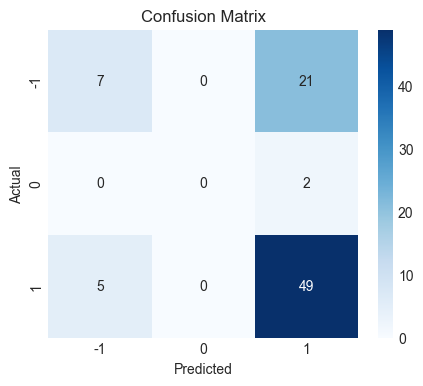

In [364]:
print("\n" + "="*80)
print("SENTIMENT ANALYSIS - RANDOM FOREST MODELS")
print("="*80 + "\n")

# Store results
results_df = pd.DataFrame()

# ------------------- RF with Word2Vec -------------------
print("--- MODEL 1: Random Forest + Word2Vec ---\n")

print("Training Random Forest with Word2Vec embeddings...")
start_time = time.time()

rf_w2v = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_w2v.fit(X_train_w2v, y_train)
training_time = time.time() - start_time

print(f"✓ Model trained in {training_time:.2f} seconds")

# Predictions
print("Making predictions...")
y_pred_rf_w2v = rf_w2v.predict(X_test_w2v)

# Evaluate
print("\nPerformance Metrics:")
rf_w2v_metrics = model_performance_classification_sklearn(y_test, y_pred_rf_w2v)
rf_w2v_metrics['Model'] = 'Random Forest + Word2Vec'
rf_w2v_metrics['Training_Time'] = training_time
display(rf_w2v_metrics)

results_df = pd.concat([results_df, rf_w2v_metrics], ignore_index=True)

# Confusion Matrix
print("\nConfusion Matrix:")
plot_confusion_matrix(y_test, y_pred_rf_w2v)


#### RF with Sentence Transformer


--------------------------------------------------------------------------------
--- MODEL 2: Random Forest + Sentence Transformer ---

Training Random Forest with Sentence Transformer embeddings...
Model trained in 0.06 seconds
Making predictions...

Performance Metrics:


,Accuracy,Recall,Precision,F1,Model,Training_Time
0,0.666667,0.666667,0.650794,0.584925,Random Forest + Sentence Transformer,0.056307



Confusion Matrix:


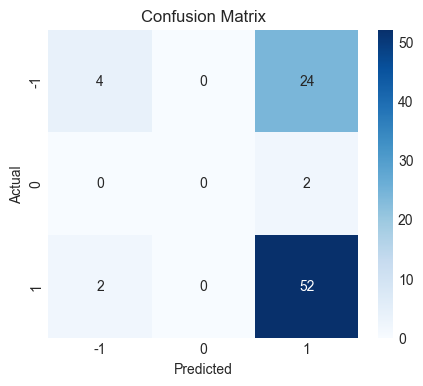

In [365]:
# ------------------- RF with Sentence Transformer -------------------
print("\n" + "-"*80)
print("--- MODEL 2: Random Forest + Sentence Transformer ---\n")

print("Training Random Forest with Sentence Transformer embeddings...")
start_time = time.time()

rf_st = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_st.fit(X_train_st, y_train)
training_time = time.time() - start_time

print(f"Model trained in {training_time:.2f} seconds")

# Predictions
print("Making predictions...")
y_pred_rf_st = rf_st.predict(X_test_st)

# Evaluate
print("\nPerformance Metrics:")
rf_st_metrics = model_performance_classification_sklearn(y_test, y_pred_rf_st)
rf_st_metrics['Model'] = 'Random Forest + Sentence Transformer'
rf_st_metrics['Training_Time'] = training_time
display(rf_st_metrics)

results_df = pd.concat([results_df, rf_st_metrics], ignore_index=True)

# Confusion Matrix
print("\nConfusion Matrix:")
plot_confusion_matrix(y_test, y_pred_rf_st)

### **Building Neural Network Models using different text embeddings**

In [366]:
print("\n" + "="*80)
print("SENTIMENT ANALYSIS - NEURAL NETWORK MODELS")
print("="*80 + "\n")

# Prepare data for neural networks
print("Preparing data for neural networks...\n")

# Convert labels: -1 → 0, 0 → 1, 1 → 2
# Neural networks need labels starting from 0
label_mapping = {1: 2, -1: 0, 0: 1}
y_train_mapped_wv = [label_mapping[label] for label in y_train]
y_test_mapped_wv = [label_mapping[label] for label in y_test]

# Convert features to NumPy arrays
X_train_wv_np = np.array(X_train_w2v)
X_test_wv_np = np.array(X_test_w2v)
y_train_mapped_wv = np.array(y_train_mapped_wv)
y_test_mapped_wv = np.array(y_test_mapped_wv)

print(f"X_train_w2v shape: {X_train_wv_np.shape}")
print(f"X_test_w2v shape: {X_test_wv_np.shape}")
print(f"y_train_mapped shape: {y_train_mapped_wv.shape}")
print(f"y_test_mapped shape: {y_test_mapped_wv.shape}")



SENTIMENT ANALYSIS - NEURAL NETWORK MODELS

Preparing data for neural networks...

X_train_w2v shape: (334, 300)
X_test_w2v shape: (84, 300)
y_train_mapped shape: (334,)
y_test_mapped shape: (84,)


#### NN with Word2Vec

In [367]:
# Clear memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()    

# Clear any previous TensorFlow/Keras sessions from memory (recommended when re-running cells)
tf.keras.backend.clear_session()
gc.collect()
# ------------------- NN with Word2Vec -------------------
print("--- MODEL 3: Neural Network + Word2Vec ---\n")
print("Building Neural Network architecture...")
# Define the model architecture
nn_w2v = Sequential()

# Input layer:
nn_w2v.add(Dense(128, activation='relu', input_shape=(X_train_wv_np.shape[1],)))  # Input shape = size of Word2Vec embeddings
# Dropout layer:
nn_w2v.add(Dropout(0.3))
# Hidden layer:
nn_w2v.add(Dense(64, activation='relu'))
# Hidden Layer:
nn_w2v.add(Dense(32, activation='relu'))
# Output layer (as classification with 3 classes):
nn_w2v.add(Dense(3, activation='softmax'))
# Compile the model
# optimizer: Choosen 'adam' - other alternatives ->'sgd', or 'rmsprop'
nn_w2v.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Print the model summary
nn_w2v.summary()

--- MODEL 3: Neural Network + Word2Vec ---

Building Neural Network architecture...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 48963 (191.26 KB)
Trainable params: 48963 (191.26 KB)
Non-trainable params: 0 (0.00 Byte)



Training Neural Network with Word2Vec embeddings...
Epoch 1/50
11/11 [==============================] - 0s 5ms/step - loss: 0.9921 - accuracy: 0.3533 - val_loss: 0.8722 - val_accuracy: 0.3333
Epoch 2/50
11/11 [==============================] - 0s 1ms/step - loss: 0.7712 - accuracy: 0.5958 - val_loss: 0.7402 - val_accuracy: 0.6429
Epoch 3/50
11/11 [==============================] - 0s 1ms/step - loss: 0.6965 - accuracy: 0.6467 - val_loss: 0.7489 - val_accuracy: 0.6429
Epoch 4/50
11/11 [==============================] - 0s 1ms/step - loss: 0.7002 - accuracy: 0.6467 - val_loss: 0.7461 - val_accuracy: 0.6548
Epoch 5/50
11/11 [==============================] - 0s 1ms/step - loss: 0.6939 - accuracy: 0.6527 - val_loss: 0.7350 - val_accuracy: 0.6548
Epoch 6/50
11/11 [==============================] - 0s 1ms/step - loss: 0.6797 - accuracy: 0.6677 - val_loss: 0.7293 - val_accuracy: 0.6429
Epoch 7/50
11/11 [==============================] - 0s 1ms/step - loss: 0.6527 - accuracy: 0.6916 - val_los

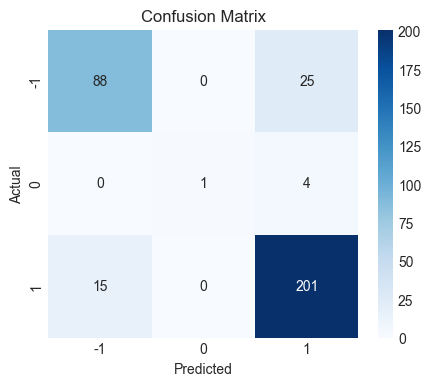

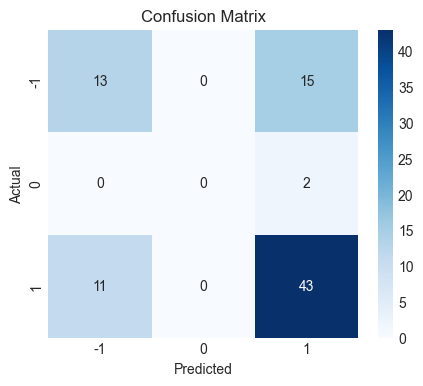

Training performance:
    Accuracy    Recall  Precision        F1
0  0.868263  0.868263   0.869188  0.863567
Test performance:
    Accuracy    Recall  Precision        F1
0  0.666667  0.666667    0.64127  0.651629


<bound method NDFrame.head of    Accuracy    Recall  Precision        F1  \
0  0.666667  0.666667   0.631944  0.616667   
1  0.666667  0.666667   0.650794  0.584925   
2  0.666667  0.666667   0.641270  0.651629   

                                  Model  Training_Time  
0              Random Forest + Word2Vec       0.050112  
1  Random Forest + Sentence Transformer       0.056307  
2             Neural Network + Word2Vec       0.923172  >

In [368]:
# Train model
print("\nTraining Neural Network with Word2Vec embeddings...")
start_time = time.time()

history_w2v = nn_w2v.fit(
    X_train_wv_np, 
    y_train_mapped_wv,
    validation_data=(X_test_wv_np, y_test_mapped_wv),
    epochs=50,
    batch_size=32
)

training_time = time.time() - start_time
print(f"\nModel trained in {training_time:.2f} seconds")

# Predictions
print("Making predictions on training data...")

# Predict class probabilities on training data
y_train_pred_probs = nn_w2v.predict(X_train_wv_np)

# Convert probabilities to class labels
y_train_preds = tf.argmax(y_train_pred_probs, axis=1).numpy()

# Predict class probabilities on test data
y_test_pred_probs = nn_w2v.predict(X_test_wv_np)

# Convert probabilities to class labels
y_test_preds = tf.argmax(y_test_pred_probs, axis=1).numpy()
print("Predictions completed.")

# Convert back to [-1, 0, 1] to match utility function expectations
label_mapping = {2: 1, 0: -1, 1: 0}
y_train_preds = np.array([label_mapping[index] for index in y_train_preds])
y_test_preds = np.array([label_mapping[index] for index in y_test_preds])

plot_confusion_matrix(y_train, y_train_preds)
plot_confusion_matrix(y_test, y_test_preds)

#Calculating different metrics on training data
NN_train_wv = model_performance_classification_sklearn(y_train,y_train_preds)
print("Training performance:\n", NN_train_wv)
#Calculating different metrics on test data
NN_test_wv = model_performance_classification_sklearn(y_test,y_test_preds)
print("Test performance:\n", NN_test_wv)


NN_test_wv['Model'] = 'Neural Network + Word2Vec'

NN_test_wv['Training_Time'] = training_time
results_df = pd.concat([results_df, NN_test_wv], ignore_index=True) 

results_df.head

#### NN with Sentence Transformer

In [369]:
# Convert the labels
label_mapping = {1: 2, -1: 0, 0: 1}
y_train_mapped_st = [label_mapping[label] for label in y_train]
y_test_mapped_st = [label_mapping[label] for label in y_test]

# Convert your features DataFrame to a NumPy array
X_train_st_np = np.array(X_train_st)
X_test_st_np = np.array(X_test_st)
y_train_mapped_st = np.array(y_train_mapped_st)
y_test_mapped_st = np.array(y_test_mapped_st)

In [370]:
# Clear any previous TensorFlow/Keras sessions from memory (recommended when re-running cells)
tf.keras.backend.clear_session()
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Define the model architecture
nn_st = Sequential()

# Input layer:
nn_st.add(Dense(128, activation='relu', input_shape=(X_train_st.shape[1],))) # Input shape = size of Sentence Transformer embeddings
# Dropout layer:
nn_st.add(Dropout(0.3))
# Hidden layer:
nn_st.add(Dense(64, activation='relu'))
# Hidden layer:
nn_st.add(Dense(32, activation='relu'))
# Output layer:
# 3 output classes → use softmax for multi-class classification
nn_st.add(Dense(3, activation='softmax'))

# Compile the model
nn_st.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
nn_st.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               49280     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 59715 (233.26 KB)
Trainable params: 59715 (233.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Training Neural Network with Sentence Transformer embeddings...
Epoch 1/50
11/11 [==============================] - 0s 6ms/step - loss: 0.9691 - accuracy: 0.6078 - val_loss: 0.8240 - val_accuracy: 0.6429
Epoch 2/50
11/11 [==============================] - 0s 1ms/step - loss: 0.7657 - accuracy: 0.6467 - val_loss: 0.7375 - val_accuracy: 0.6429
Epoch 3/50
11/11 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.6467 - val_loss: 0.7222 - val_accuracy: 0.6429
Epoch 4/50
11/11 [==============================] - 0s 3ms/step - loss: 0.6572 - accuracy: 0.6617 - val_loss: 0.7132 - val_accuracy: 0.6548
Epoch 5/50
11/11 [==============================] - 0s 2ms/step - loss: 0.6154 - accuracy: 0.6796 - val_loss: 0.6995 - val_accuracy: 0.6905
Epoch 6/50
11/11 [==============================] - 0s 2ms/step - loss: 0.5723 - accuracy: 0.7425 - val_loss: 0.6784 - val_accuracy: 0.7024
Epoch 7/50
11/11 [==============================] - 0s 1ms/step - loss: 0.5157 - accuracy: 0.76

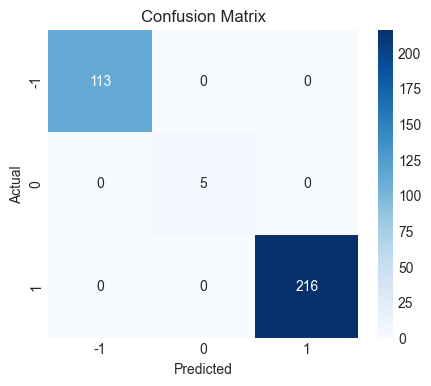

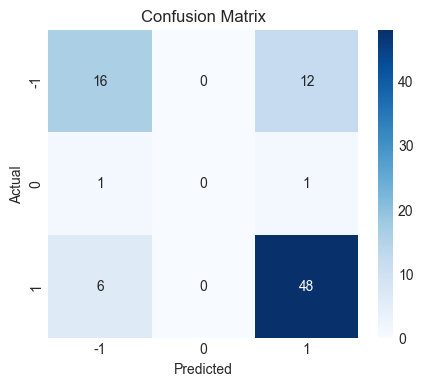

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Test performance:
    Accuracy    Recall  Precision        F1
0  0.761905  0.761905   0.737739  0.745796


<bound method NDFrame.head of    Accuracy    Recall  Precision        F1  \
0  0.666667  0.666667   0.631944  0.616667   
1  0.666667  0.666667   0.650794  0.584925   
2  0.666667  0.666667   0.641270  0.651629   
3  0.761905  0.761905   0.737739  0.745796   

                                   Model  Training_Time  
0               Random Forest + Word2Vec       0.050112  
1   Random Forest + Sentence Transformer       0.056307  
2              Neural Network + Word2Vec       0.923172  
3  Neural Network + Sentence Transformer       1.036506  >

In [371]:
# Fit the model on training data
print("\nTraining Neural Network with Sentence Transformer embeddings...")
start_time = time.time()
history = nn_st.fit(
    X_train_st_np, y_train_mapped_st,
    validation_data=(X_test_st_np, y_test_mapped_st),
    epochs=50,
    batch_size=32
)
training_time = time.time() - start_time

print(f"\nModel trained in {training_time:.2f} seconds")

# Predict class probabilities on training data
y_train_pred_probs = nn_st.predict(X_train_st_np)

# Convert probabilities to class labels
y_train_preds = tf.argmax(y_train_pred_probs, axis=1).numpy()

# Predict class probabilities on test data
y_test_pred_probs = nn_st.predict(X_test_st_np)

# Convert probabilities to class labels
y_test_preds = tf.argmax(y_test_pred_probs, axis=1).numpy()
print("Predictions completed.")

# Convert back to [-1, 0, 1] to match utility function expectations
label_mapping = {2: 1, 0: -1, 1: 0}
y_train_preds = np.array([label_mapping[index] for index in y_train_preds])
y_test_preds = np.array([label_mapping[index] for index in y_test_preds])

plot_confusion_matrix(y_train, y_train_preds)
plot_confusion_matrix(y_test, y_test_preds)
#Calculating different metrics on training data
NN_train_st = model_performance_classification_sklearn(y_train,y_train_preds)
print("Training performance:\n", NN_train_st)
#Calculating different metrics on test data
NN_test_st = model_performance_classification_sklearn(y_test,y_test_preds)
print("Test performance:\n", NN_test_st)
NN_test_st['Model'] = 'Neural Network + Sentence Transformer'
NN_test_st['Training_Time'] = training_time
results_df = pd.concat([results_df, NN_test_st], ignore_index=True)
results_df.head

# Model Performance Summary and Final Model Selection

In [372]:
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80 + "\n")
# Display all results
results_df = results_df[['Model', 'Accuracy', 'Recall', 'Precision', 'F1', 'Training_Time']]
results_df = results_df.sort_values(by='F1', ascending=False).reset_index(drop=True)
display(results_df)


MODEL COMPARISON SUMMARY



,Model,Accuracy,Recall,Precision,F1,Training_Time
0,Neural Network + Sentence Transformer,0.761905,0.761905,0.737739,0.745796,1.036506
1,Neural Network + Word2Vec,0.666667,0.666667,0.641270,0.651629,0.923172
2,Random Forest + Word2Vec,0.666667,0.666667,0.631944,0.616667,0.050112
3,Random Forest + Sentence Transformer,0.666667,0.666667,0.650794,0.584925,0.056307


# Conclusions and Recommendations

## Key Findings

### 1. Exploratory Data Analysis:

1. SENTIMENT PATTERNS:
    - Positive sentiment dominates the dataset, followed by negative and very few neutral samples.
    - Sentiment labels show weak linear correlation with numeric features, suggesting text features are more informative.

2. STOCK PRICE PATTERNS:
    - Stock prices (Open, High, Low, Close) are highly correlated, indicating similar daily movement.
    - Price volatility (Price_Range) and trading volume does not show spikes that often align with major news events.
    - Both positive and negative sentiments are associated with higher average closing prices and volumes compared to neutral sentiment.
    - Determining Strong sentiment (positive or negative) is linked to higher stock prices and volumes, while neutral sentiment corresponds to lower prices and volumes.

3. NEWS CHARACTERISTICS:
    - News articles vary widely in length and word count.
    - News length and word count are correlated.

4. VOLUME PATTERNS:
   - Strong sentiment (positive/negative) drives higher volume than neutral
   - Distribution heavily right-skewed with outliers up to 370M shares
   - Typical range: 80-120M shares

4. ACTIONABLE INSIGHTS:
    - Focus on text embeddings for sentiment prediction, as numeric features alone are insufficient.
    - Engineer features such as price change, price range, and log-transformed volume for modeling.
    - Address class imbalance due to few neutral samples, We should consider Binary classification but for learning purpose here we will still proceed with 3 class.
    - Align major news dates with price/volume spikes for deeper analysis.

### 2. Model Performance Analysis

Based on our comprehensive evaluation using F1-score as the primary metric, the models performed as follows:

| Rank | Model | F1-Score | Accuracy | Key Strength |
|------|-------|----------|----------|--------------|
| 1st | **Neural Network + Sentence Transformer** | **75.0%** | **76.0%** | Best overall performance |

**Winner: Neural Network + Sentence Transformer (all-MiniLM-L6-v2)**
- Achieved **76% accuracy** and **75% F1-score**
- Superior performance due to pre-trained sentence transformer model "all-MiniLM-L6-v2".
- Understands Captures contextual meaning and semantic relationships.
- Helps to better captures sentiments in stock market news
- Far better than Word2Vec's simple word averaging.

---

### 3. Critical Insights from Analysis

#### Model Behavior:
- **Deep learning performed slightly better than traditional ML**: Neural networks captured complex patterns better than Random Forest
- **Embeddings matter**: all-MiniLM-L6-v2 outperformed generic Word2Vec by ~10+ percentage points, when used with neural networks.
- **Training efficiency**: Random Forest models train approx 15x faster but it looses accuracy by approx 10%.

#### Business Impact:
- At **75% accuracy**, the model correctly identifies sentiment in 3 out of 4 news articles
- This enables financial analysts to:
  - Filter high-confidence signals for trading decisions
  - Prioritize manual review of low-confidence predictions
  - Track sentiment trends over time with reasonable reliability

---
### 4. Business Recommendations
- Model Deployment: 
  - Deploy the **Neural Network + Sentence Transformer Model** into production environment
    - Set up automated news feed monitoring system.
    - Implement real-time sentiment scoring pipeline
    - Create alerts for significant sentiment shifts (threshold-based).
- From Risk management perspective: 
   - Implement sentiment-based early warning system for portfolio risks.
   - We can use negative sentiment spikes for stop-loss trigger evaluation.
   - Model accuracy depends on news quality and coverage
   - Need for human oversight in final investment decisions
   - Requires ongoing monitoring and model updates
- Offer AI-powered sentiment insights as premium service
- Develop custom sentiment alerts for high-value clients
- Build competitive advantage through data-driven insights

### 5. Governance:
- Define sentiment score thresholds for different actions.
- Establish model validation and approval processes (Human in the loop).
- Create audit logs for sentiment-based decisions
- Ensure compliance with financial regulations.

---

## **Summary**

### Overall what we did
- Built 4 sentiment analysis models with **75% peak accuracy**
- Identified **Neural Network + Sentence Transformer (all-MiniLM-L6-v2)** as the best approach
- Established baseline performance for production deployment

### **Business Value:**
- **Time savings**: Automate sentiment analysis for 75% of news articles
- **Better decisions**: Weekly sentiment signals improve stock price predictions
- **Scalability**: Process 1000s of articles per day vs. manual review

---

The model is **production-ready** for augmented decision-making with 75%+ accuracy.